<a href="https://colab.research.google.com/github/gii-pan/lia1-2023-1/blob/main/Atividade_FastAI_%C3%89_um_p%C3%A1ssaro%3F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## É um pássaro?

O passo a passo necessário: 

1. Utilizar DuckDuckGo para pesquisar imagens de pássaros;
1. Utilizar DuckDuckGo para pesquisar imagens de forestas;
1. Realizar o Fine-tune em uma rede neural pré treinada para reconhecer as duas categorias citadas (pássaro/foresta);
1. Testar o modelo com uma imagem de pássore e verificar se funciona.

## Etapa 1: Download de imagens de pássaros e florestas

In [ ]:
# Instalando bibliotecas
!pip install -Uqq duckduckgo_search
!pip install -Uqq fastai

# Importando métodos
from duckduckgo_search import ddg_images
from fastcore.all import *
from fastdownload import download_url
from fastai.vision.all import *
from time import sleep

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 kB 3.1 MB/s eta 0:00:00


In [ ]:
# Declaração de função para pesquisar imagens
def search_images(term, max_images=200): return L(ddg_images(term, max_results=max_images)).itemgot('image')

Começamos adquirindo as URLs: 

In [ ]:
urls = search_images('bird photos', max_images=1)
urls[0]

'https://www.almanac.com/sites/default/files/image_nodes/bluebird-3456115_1920.jpg'

Depois baixando a url e observando a imagem: 



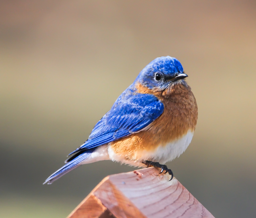

In [ ]:
dest = 'bird.jpg'
download_url(urls[0], dest, show_progress=False)

im = Image.open(dest)
im.to_thumb(256,256)

---

Realizando o mesmo para as imagens de floresta: 

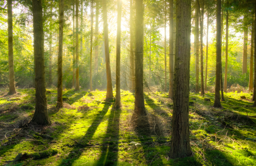

In [ ]:
download_url(search_images('forest photos', max_images=1)[0], 'forest.jpg', show_progress=False)
Image.open('forest.jpg').to_thumb(256,256)

Como a pesquisa pelas imagens apresentaram bons resultados, o procedimento a seguir buscar 200 imagens de cada grupo (pássaros e florestas) e salva as fotos em diferentes pastas: 

In [ ]:
searches = 'forest','bird'
path = Path('bird_or_not')

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pausa entre as pesquisas para evitar sobrecarregar o servidor
    download_images(dest, urls=search_images(f'{o} sun photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} shade photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

## Etapa 2: Treinando o modelo

Algumas fotos podem apresentar erros ao tentar realizar o download. Dessa forma, realiza-se a remoção para evitar problemas: 

In [ ]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

25

Para treinar o modelo, utiliza-se um `DataLoaders`, objeto que contém o conjunto de imagens de treinamento (*training set*) e o conjunto de imagens de validação (*validation set").

Com a `fastai` cria-se esse objeto com o `DataBlock, logo abaixo tem-se imagens de exemplo: 

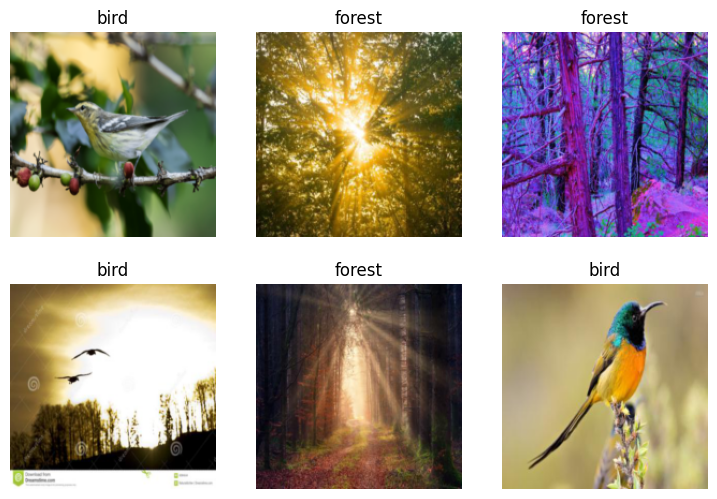

In [ ]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)

dls.show_batch(max_n=6)

Definindo os parâmetros do `DataBlock`: 

    blocks=(ImageBlock, CategoryBlock),

As entradas do modelo são imagens, e as saidas são categorias (no exemplo trabalhado, pássaros ou florestas).

    get_items=get_image_files, 

Para encontrar todas as entradas para o modelo, utiliza-se a função `get_image_files`, a qual retorna a lista de todas as imagens contidas no diretório.

    splitter=RandomSplitter(valid_pct=0.2, seed=42),

Divide os dados em treinamento e validação de forma aleatória, utilizando 20% dos dados para a validação. 

    get_y=parent_label,

Os rótulos (valores `y`) consistem no nome do `pai` de cada arquivo (ou seja, o nome da pasta em que eles estão, que será *bird*(pássaro) ou *forest*(floresta). 

    item_tfms=[Resize(192, method='squish')]

Antes de treinar, realiza-se o redimensionamento de cada imagem para 192x192 pixels. 


---



O modelo mais utilizado para visão computacional é a `resnet18`.

A `fastai`possui um método de apoio `fine_tune()`o qual automaticamente utiliza as melhores práticas para realizar o fine tuning de modelos pré treinados.

In [ ]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,0.370884,0.091401,0.009877,02:40


epoch,train_loss,valid_loss,error_rate,time
0,0.075959,0.057994,0.009877,04:01
1,0.040685,0.104035,0.014815,04:17
2,0.022942,0.090775,0.009877,04:18


Aplicar o fine-tuning em um modelo significa ajustar os pesos de forma que o modelo pré treinado com outro dataset (conjunto de dados) aprenda a reconhecer os novos dados a serem utilizados. 

## Etapa 3: Utilizando o modelo

Como o modelo classifica a imagem do início do notebook: 

In [ ]:
is_bird,_,probs = learn.predict(PILImage.create('bird.jpg'))
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}")

This is a: bird.
Probability it's a bird: 1.0000
